# Expressions containing NDArray objects

Python-Blosc2 implements a powerful way to operate with NDArray arrays and other objects, called "lazy expressions".  A lazy expression is a lightweight object which stores a desired computation symbolically, with references to its operands (stored on disk or in memory), but does not execute until data is explicitly requested, e.g. if a slice of the computation result is requested. The lazy expression will then execute, but only on the necessary portion of the data, making it especially efficient, and avoiding large in-memory computations.

In this tutorial, we will see how to do such lazy computations, which are especially useful when working with large arrays, owing to this avoidance of costly in-memory temporaries.


In [1]:
!pip install memory-profiler
%load_ext memory_profiler

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import blosc2
import time

## A simple example
First, let's create a couple of NDArray arrays. We're going to write them to disk since in principle we are interested in large arrays (so big that they can't fit in memory).

In [3]:
shape = (500, 1000)
a = blosc2.linspace(0, 1, np.prod(shape), dtype=np.float32, shape=shape, urlpath="a.b2nd", mode="w")
b = blosc2.linspace(1, 2, np.prod(shape), dtype=np.float64, shape=shape, urlpath="b.b2nd", mode="w")

Now, let's create an expression that involves `a` and `b`, called `c`.

In [4]:
c = a**2 + b**2 + 2 * a * b + 1
print(c.info)  # at this stage, the expression has not been computed yet

type       : LazyExpr
expression : ((((o0 ** 2) + (o1 ** 2)) + ((2 * o0) * o1)) + 1)
operands   : {'o0': 'a.b2nd', 'o1': 'b.b2nd'}
shape      : (500, 1000)
dtype      : float64



We see that the type of `c` is a `LazyExpr` object.  This object is a placeholder for the actual computation that will be done when we compute the expression.  This is a very powerful feature because it allows us to build complex expressions without actually computing anything until we really need the result (or a portion of the result).

Now, let's compute it. `LazyExpr` objects follow the [LazyArray interface](../../reference/lazyarray.html), and this provides several ways for performing the computation, depending on the object we want as the desired output.

#### 1. Returning a NDArray array
First, let's use the `compute` method.  The result will be another NDArray array:

In [5]:
d = c.compute()  # compute the expression
print(f"Class: {type(d)}")
print(f"Compression ratio: {d.schunk.cratio:.2f}x")

Class: <class 'blosc2.ndarray.NDArray'>
Compression ratio: 1.89x


We can specify different compression parameters for the result.  For example, we can change the codec to `ZLIB`, use the bitshuffle filter, and set the compression level to 9:

In [6]:
cparams = blosc2.CParams(codec=blosc2.Codec.ZLIB, filters=[blosc2.Filter.BITSHUFFLE], clevel=9)
d = c.compute(cparams=cparams)
print(f"Compression ratio: {d.schunk.cratio:.2f}x")

Compression ratio: 2.01x


Or, we can write the result to disk:

In [7]:
d = c.compute(urlpath="result.b2nd", mode="w")
!ls -lh result.b2nd

-rw-rw-r-- 1 lshaw lshaw 2,1M ago  6 16:56 result.b2nd


or compute just a slice of the result, which will only compute the necessary chunks of the result which intersect with the desired slice:

In [8]:
d_slice = c.compute(item=slice(100, 200, 1))  # compute a slice of the expression

What is happening when we call the ``compute`` method? The operands are all NDArray arrays, chunked and stored on disk. When the compute method is called, the expression is executed, chunk-by-chunk, and the result stored, chunk-by-chunk. Hence at any given time, only a small amount of data (a chunk for each operand and the result) must be operated on in memory; and secondly, the computation is only performed on the necessary chunks required to give the result slice. Both operands and results are stored on disk here, so in fact you can operate with very large arrays in a very small memory footprint.

#### 2. Returning a NumPy array
Now, let's compute the expression and store the result in a NumPy array.  For this, we will use the `__getitem__` method. We may execute the expression with a slice, or without it, in which case the whole result will be computed:

In [9]:
npd = d[100:200]  # compute a slice of the expression
print(f"Class: {type(npd)}, shape: {npd.shape}")
npd = d[:]  # compute the whole expression
print(f"Class: {type(npd)}, shape: {npd.shape}")

Class: <class 'numpy.ndarray'>, shape: (100, 1000)
Class: <class 'numpy.ndarray'>, shape: (500, 1000)


As you can see, in either case the result is a NumPy array now.

Depending on your needs, you can choose to get the result as a NDArray array or as a NumPy array.  The former is more storage efficient, but the latter is more flexible when interacting with other libraries that do not support NDArray arrays, or for reading out data.

## Saving expressions to disk
Lazy expressions may be saved to disk if all operands they refer to are also stored on disk.  For this, use the `save` method of ``LazyArray`` objects.  For example, let's save the expression `c` to disk:

In [10]:
c = a**2 + b**2 + 2 * a * b + 1
c.save(urlpath="expr.b2nd")

We may then load the expression with the `open` function, and check to see that the addresses of the operands are correct, and proceed to computation:

In [11]:
c2 = blosc2.open("expr.b2nd")
print(c2.info)
d2 = c2.compute()
print(f"Result shape: {d2.shape}")

type       : LazyExpr
expression : (o0 ** 2 + o1 ** 2 + 2 * o0 * o1 + 1)
operands   : {'o0': 'a.b2nd', 'o1': 'b.b2nd'}
shape      : (500, 1000)
dtype      : float64

Result shape: (500, 1000)


## A more complicated example
#### Functions
Lazy expressions also support many standard functions (essentially those available in NumPy), such as `sin`, `cos`, `exp`, `log`, etc.  Let's see an example:

In [12]:
new_expr = blosc2.sin(a) + blosc2.cos(b) + blosc2.exp(a * b)
print(f"Class: {type(new_expr)}")
new_expr[1, :4]

Class: <class 'blosc2.lazyexpr.LazyExpr'>


array([1.5426243 , 1.54262662, 1.54262895, 1.54263128])

Ok, let's put the computation engine throug its paces with some proper computations.

In [13]:
# --- Experiment Setup ---
scale = 1.0  # Scale factor for the grid
width, height = np.array((100, 100)) * scale  # Size of the grid
n_frames = int(100 * scale)  # Raise this for more frames
dtype = np.float64  # Data type for the grid

# --- Coordinate creation ---
x = blosc2.linspace(0, n_frames, n_frames, dtype=dtype)
y = blosc2.linspace(-4 * np.pi, 4 * np.pi, width, dtype=dtype)
z = blosc2.linspace(-4 * np.pi, 4 * np.pi, height, dtype=dtype)
X = blosc2.expand_dims(blosc2.expand_dims(x, 1), 2)  # Shape: (N, 1, 1)
Y = blosc2.expand_dims(blosc2.expand_dims(y, 0), 2)  # Shape: (1, N, 1)
Z = blosc2.expand_dims(blosc2.expand_dims(z, 0), 0)  # Shape: (1, 1, N)


We can in fact apply NumPy functions to the blosc2 NDArray arrays and the result will still be a lazyexpr. Moreover, broadcasting is handled by lazyexprs internally, and we can even get some rapid metadata about the result without computing anything.

In [14]:
def genexpr():
    time_factor = X * Y * 0.001
    R = np.sqrt(Y**2 + Z**2)
    theta = np.arctan2(Z, Y)
    return np.sin(R * 3 - time_factor * 2) * np.cos(theta * 3)
%timeit genexpr()
%memit expr = genexpr()
print(f'Despite applying NumPy functions, the result is still of {type(expr)}!')
print(f"Result will have shape {expr.shape} and dtype {expr.dtype}")

65.9 μs ± 78.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
peak memory: 244.24 MiB, increment: 0.00 MiB
Despite applying NumPy functions, the result is still of <class 'blosc2.lazyexpr.LazyExpr'>!
Result will have shape (100, 100, 100) and dtype float64


Now let's generate an animation:

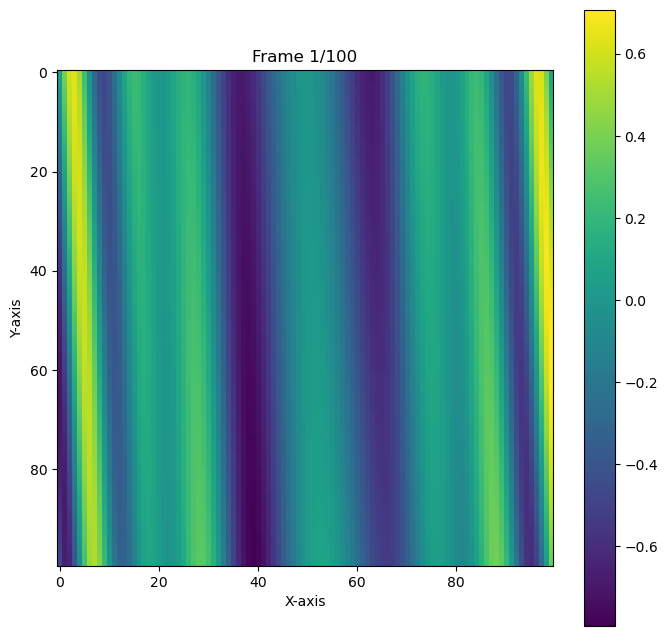

In [38]:
fig = plt.figure(figsize=(8, 8))
im = plt.imshow(expr[:,:,0], cmap="viridis")
fig.colorbar(im)
plt.title("Blosc2 Animated Plot")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

def update(frame_num):
    # Evaluate the expression for the current frame on the fly
    im.set_array(expr[:, :, frame_num])
    plt.title(f"Frame {frame_num + 1}/{n_frames}")
    return im,

ani = FuncAnimation(fig, update, frames=n_frames, interval=1, blit=True, repeat=True)
plt.show()

#### Reductions
Reductions (mean, sum, variance etc.) are useful in many applications, such as data science, for summarising or *reducing* data. Reductions may also be incorporated as part of expressions, although their behaviour is somewhat different to that of other functions.  Let's see an example of a reduction:

In [12]:
c = (a + b).sum()
c

np.float64(999999.9999999473)

As we can see, the result is a scalar (not a ``LazyExpr``). This is because reductions in expressions are always executed "eagerly" (i.e. on creation of the lazy expression).
We can also specify the axis for the reduction:

In [13]:
c = (a + b).sum(axis=1)
print(f"Shape of c: {c.shape}")
# Show the first 4 elements of the result
c[:4]

Shape of c: (500,)


array([1001.998004  , 1005.998012  , 1009.99802   , 1013.99802799])

Reductions can also be part of more complex expressions, but in this case the final result may be a lazy expression (only the reduction is executed eagerly and its result stored as an operand in the full expression):

In [14]:
c = (a + b).sum(axis=0) + 2 * a + 1
print(f"Type of c: {type(c)}. Shape of c: {c.shape}")
# Show the first 4 elements of the result
c[0, 0:4]

Type of c: <class 'blosc2.lazyexpr.LazyExpr'>. Shape of c: (500, 1000)


array([1000.0010009 , 1000.00300336, 1000.00500598, 1000.00700854])

The ``__getitem__`` method causes the remainder of the expression to execute (only using the relevant slices of the operands, including the result of the reduction `(a + b).sum(axis=0)`).

Note that the result of the reduction above has a different shape `(500,)` to the operand `a`, but the expression is still computed correctly.  This is because the shape of the reduction is *compatible* with the shape of the operands according to the broadcasting convention.

## Broadcasting

NumPy arrays support broadcasting, and so do NDArray arrays.  Let's see an example:


In [15]:
b2 = b[0]  # take the first row of b
print(f"Shape of a: {a.shape}, shape of b2: {b2.shape}")

Shape of a: (500, 1000), shape of b2: (1000,)


We see that the shapes of `a` and `b2` are different.  However, as the shapes are compatible, we can still operate with them and the broadcasting will be done automatically (à la NumPy) and efficiently:

In [16]:
c2 = a + b2
d2 = c2.compute()
print(f"Shape: {d2.shape}")

Shape: (500, 1000)


## BONUS: Querying and Filtering NDArray arrays

The Blosc2 compute engine enables one to perform lazy queries on NDArray arrays with structured types.  Let's see an example.

In [17]:
N = 1000_000
rng = np.random.default_rng(seed=1)
it = ((-x + 1, x - 2, rng.normal()) for x in range(N))
sa = blosc2.fromiter(
    it, dtype=[("A", "i4"), ("B", "f4"), ("C", "f8")], shape=(N,), urlpath="sa-1M.b2nd", mode="w"
)
print("First 3 rows:\n", sa[:3])

First 3 rows:
 [( 1, -2., 0.34558419) ( 0, -1., 0.82161814) (-1,  0., 0.33043708)]


One could select rows depending on the value of the different fields (`A`, `B`, `C`) in the following way, using a lazy boolean index

In [18]:
A = sa["A"]
B = sa["B"]
C = sa["C"]
expr = sa[A > B]
print(type(expr))
expr[:]

<class 'blosc2.lazyexpr.LazyExpr'>


array([(1, -2., 0.34558419), (0, -1., 0.82161814)],
      dtype=[('A', '<i4'), ('B', '<f4'), ('C', '<f8')])

In fact we can do the same in a more compact way by using an expression in string form inside the brackets. In both cases the result is a `LazyExpr` object, on which we then need to call the `__getitem__` or ``compute`` method to get an actual array-like result:

In [19]:
expr = sa["A > B"]
print(type(expr))
expr[:]

<class 'blosc2.lazyexpr.LazyExpr'>


array([(1, -2., 0.34558419), (0, -1., 0.82161814)],
      dtype=[('A', '<i4'), ('B', '<f4'), ('C', '<f8')])

The expression can be arbitrarily complex:

In [20]:
expr = sa["(A > B) & (sin(C) > .5)"]
expr[:]

array([(0, -1., 0.82161814)],
      dtype=[('A', '<i4'), ('B', '<f4'), ('C', '<f8')])

Queries will also work on the individual fields (of type ``NDField``), as they still possess references to the other fields of the parent array:

In [21]:
print(type(C))
C["A > B"][:]

<class 'blosc2.ndarray.NDField'>


array([0.34558419, 0.82161814])

Reductions are also supported, although since the array dtype is bespoke, the ``sum`` method fails on the full array


In [22]:
C["((C > 0) & (B < 0))"].sum()  # succeeds
# sa["((C > 0) & (B < 0))"].sum() # fails

np.float64(1.1672023355659444)

Finally, more complex queries can be done using the `where()` function.  For example, let's sum all the rows with the maximum of field `A` or field `B`:

In [23]:
blosc2.where(A > B, A, B).sum()

np.float32(499997670000.0)

Combining all this weaponry allows you to query your data quickly. As the computation is lazy, all the operations are grouped and executed together for maximum performance. The only exception is that, when a reduction is found, it is computed eagerly, but it can still be part of more general expressions, and can be saved to and loaded from disk.

Now that we're finished, let's delete the files we wrote to memory to clean up our directory.


In [24]:
blosc2.remove_urlpath("a.b2nd")
blosc2.remove_urlpath("b.b2nd")
blosc2.remove_urlpath("expr.b2nd")
blosc2.remove_urlpath("sa-1M.b2nd")
blosc2.remove_urlpath("result.b2nd")

## Summary

In this section, we have seen how to perform computations with NDArray arrays: how to create lazy expressions, compute them, and save them to disk. Also, we have looked at performing reductions, broadcasting, queries and combinations of all three. Lazy expressions allow you to build and compute complex computations from operands that can be in-memory, on-disk or remote (see [`C2Array`](reference/c2array.html)) in a simple and effective way.